# ODE  model of NeuroImaging with Bayesian Inference in Numpyro

:::

:post: April 12, 2024
:tags: ODE model in Nympyro
:category: Intermediate, Demo
:author: Meysam HASHEMI, INS, AMU, Marseille.
:acknowledgment: Nina BLADY, Cyprien DAUTREVAUX and Matthieu GILSON, and Marmadule WOODMAN. 

:::

In [1]:
import os
import sys
import time
import errno
import timeit
import pathlib

import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [2]:
import jax 
import jax.numpy as jnp
from jax import grad, vmap, lax, random
from jax.experimental.ode import odeint

In [3]:
import numpyro as npr
from numpyro import sample, plate, handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, init_to_value

In [4]:
npr.set_platform("cpu")

In [5]:
#See the dependency at last cell!
print(f"Numpy version: {np.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {npr.__version__}")
print(f"Arviz version: {az.__version__}")

Numpy version: 1.24.3
JAX version: 0.4.23
Numpyro version: 0.14.0
Arviz version: 0.17.1


In [6]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [7]:
az.style.use("arviz-darkgrid")
colors_l = ["#A4C3D9", "#7B9DBF", "#52779F", "#2A537E"] 

In [8]:
cwd = os.getcwd()
main_path = str(pathlib.Path.cwd().parent)
sys.path.append(main_path) # Path to import the model and solver

output_dir= cwd + '/output_numpyro/'
! mkdir -p $output_dir

## Purpose

The purpose of this notebook is to demonstrate how to perform Bayesian inference using Numpyro's NUTS on a system of ordinary differential equations (ODEs). For an example of ODEs in Numpyro, see ref [1]. The application is to model and fit neuroimaging data such as ERP/EEG/MEG recording (see Ref [2]).

The accuracy and efficiency of different samplers (gradient-free and gradient-based) have been compared in DCM Refs [3,4]. The conclusion is that gradient-free samplers are not powerful enough for this model, and HMC is state-of-the-art for sampling on such high-dimensional models with (nonlinear) correlated parameters. Here we benefit from automatic algorithms and automatic gradient calculation in PPLs such as Numpyro, especially with JAX's JIT acceleration. Nevertheless, multimodality is omnipresent for such high-dimensional parameters and nonlinear correlated parameters. 
   

### Key Conclusions

We propose solutions for convergence, such as increasing the max_tree_depth and decreasing target_accept_prob, to avoid issues with small step size. Remember that a smaller step size in HMC leads to heavier computational costs.

Importantly, we propose two main solutions to deal with multimodality:

    Initializing at the tail of the prior.

    Weighted stacking of the chains


In this demo, we focus on running the chains with initlization at the tail of prior, to reach convergence for all chains. For the Weighted stacking of the chains, see the advanced notebook name as MultimodalityRemedy.

Refs: 

1) https://num.pyro.ai/en/stable/examples/ode.html
    

2) https://www.sciencedirect.com/science/article/abs/pii/S1053811905008013


3) https://www.sciencedirect.com/science/article/pii/S1053811915001846


4) https://www.sciencedirect.com/science/article/pii/S1053811915006540


## Background

### Motivation

Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  A natural choice to estimate the values and uncertainty of model parameters given experimental data is Bayesian inference.  However, ODEs can be challenging to specify and solve in the Bayesian setting, therefore, this notebook steps through multiple methods for solving an ODE inference problem using JAX's Odeint. Alternative is to use diffrax, which can be found in forward simuations in the repo. The neural mass model used in this example has often been used in dynamical cuasal modeling and other approaches to fit various neuroimaging data such as ERP/EEG/MEG.

### Neural Mass Model

The mode of Olivier David et al describes the interaction between theree neural populations of pyramidal (x9), 
inhibitory interneuron (x7) 
spiny-stellate cells (x1).

In [9]:
main_path

'/Users/Meysam/WORK2/CurrentWork_codes/DCM_ERP_PPLs'

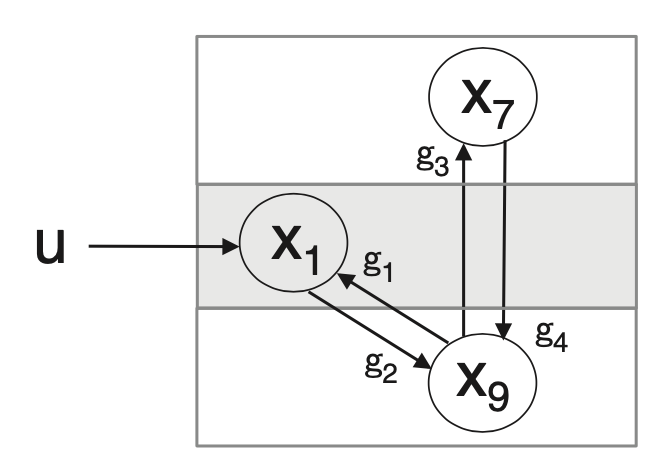

In [10]:
from IPython.display import Image
Image(filename='../Images/model.png', width=400)

This ODE given by:




\begin{array}{l}
\frac{dx_{1}(t)}{dt} = x_{4}(t) \\
\frac{dx_{2}(t)}{dt} = x_{5}(t) \\
\frac{dx_{3}(t)}{dt} = x_{6}(t) \\
\frac{dx_{7}(t)}{dt}  = x_{8}(t) \\
\frac{dx_{4}(t)}{dt} = \frac{{h_{e}(g_{1}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5) + u)}}{{\tau_{e}}} - \frac{{x_{1}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{4}(t)}}{{\tau_{e}}} \\
\frac{dx_{5}(t)}{dt}  = \frac{{g_{2}(\frac{1}{e^{-0.56x_{1}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{2}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{5}(t)}}{{\tau_{e}}} \\
\frac{dx_{6}(t)}{dt}  = \frac{{g_{4}(\frac{1}{e^{-0.56x_{7}(t-\delta)}+1} - 0.5)}}{{\tau_{i}}} - \frac{{x_{3}(t)}}{{\tau_{i}^{2}}} - \frac{{2x_{6}^{t}}}{{\tau_{i}}} \\
\frac{dx_{8}(t)}{dt}  = \frac{{g_{3}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{7}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{8}(t)}}{{\tau_{e}}} \\
\frac{dx_{9}(t)}{dt}  = x_{5}(t) - x_{6}(t)
\end{array}



The state vector $X(t)=[x_1(t), ...x_9(t)]$ comprises the densities of activity of nerural populations.  Parameters $\boldsymbol{\theta}=[g_1, g_2, g_3, g_4, \delta,\tau_i, h_i, \tau_e, h_e, u ]$ are the unknowns that we wish to infer from experimental observations.  

$x(0)$ is the initial values of the states needed to solve the ODE, and are fixed to zero for all variables. 


The unknown model parameters which represent the following:  
* $g_1, g_2, g_3, g_4$ are connection strengths.
* $\delta$ is the intrinsic delay.
* $h_{e,i}$ are maximum amplitude of excitatory (e), and inhibitory (i) post-synaptic potential.
* $\tau_{e, i}$ are the excitatory (e), and inhibitory (i) rate-constant of the membrane,
* $u$  is the input to the neural population.

## Simulator

In [11]:
from ForwardModel.ERPmodel_JAX import DCM_ERPmodel, odeint_euler, odeint_huen, odeint_rk4

In [12]:
from jax import random
rng_key = random.PRNGKey(0)

In [13]:
tend = 200.0
dt = 0.1
t0 = 0.0
ts = np.arange(t0, tend + dt, dt)
nt = ts.shape[0]

In [14]:
ns = 9
x_init=np.zeros((ns))

In [15]:
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 5.77, 27.87, 7.77, 1.63, 3.94])
n_params = theta_true.shape[0]

In [16]:
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']

Run the model

In [17]:
start_time = time.time()

xs_euler = odeint_euler(DCM_ERPmodel, x_init, ts, theta_true)

print("similations took using Euler odeint (sec):" , (time.time() - start_time))

similations took using Euler odeint (sec): 0.19524192810058594


In [18]:
start_time = time.time()

xs_huen = odeint_rk4(DCM_ERPmodel, x_init, ts, theta_true)

print("similations took using Heun odeint (sec):" , (time.time() - start_time))

similations took using Heun odeint (sec): 0.30366015434265137


In [19]:
start_time = time.time()

xs_rk4 = odeint_rk4(DCM_ERPmodel, x_init, ts, theta_true)

print("similations took using RK4 odeint (sec):" , (time.time() - start_time))

similations took using RK4 odeint (sec): 0.3026711940765381


In [20]:
output_dir

'/Users/Meysam/WORK2/CurrentWork_codes/DCM_ERP_PPLs/Numpyro/output_numpyro/'

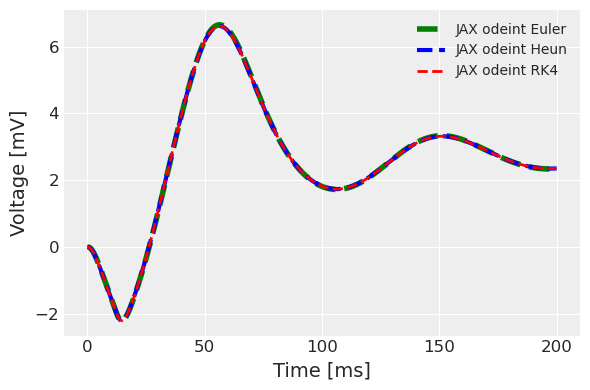

In [21]:
plt.figure(figsize=(6,4))
plt.plot(ts, xs_euler[:,8],'--', color='g', lw=4, label='JAX odeint Euler');
plt.plot(ts, xs_huen[:,8],'--', color='b', lw=3, label='JAX odeint Heun');
plt.plot(ts, xs_rk4[:,8],'--', color='r', lw=2, label='JAX odeint RK4');
plt.legend(fontsize=10, frameon=False, loc='upper right')
plt.ylabel('Voltage [mV]', fontsize=14); 
plt.xlabel('Time [ms]', fontsize=14); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();
#plt.savefig(os.path.join((output_dir),"Simulators.png"), dpi=300)
plt.show()

So, we use Euler integration, But don't worry about computional time! we put JAX's JIT on Odeint to make it more faster!

In [22]:
@jax.jit
def ERP_JAXOdeintSimuator(x_init, ts, params):

    xs_rk4 = odeint_euler(DCM_ERPmodel, x_init, ts, params)    
    x_py=xs_rk4[:,8]
    
    return x_py

The initial compilation takes a bit of time, but after that, it flies through the air!

In [23]:
start_time = time.time()

xpy_jax=ERP_JAXOdeintSimuator(x_init, ts, theta_true)

print("similations with compiling took (sec):" , (time.time() - start_time))

similations with compiling took (sec): 0.15666699409484863


In [24]:
start_time = time.time()

xpy_jax=ERP_JAXOdeintSimuator(x_init, ts, theta_true)

print("similations using JAX's JIT took (sec):" , (time.time() - start_time))

similations using JAX's JIT took (sec): 0.0005350112915039062


## Synthetic Observation

We assume that we only have accessto the activity of pyramidfal neurons, and for the sake of sppeding the computational time, we downsample the simuations.

In [25]:
#observation noise
sigma_true = 0.1 

In [26]:
xpy_jax = ERP_JAXOdeintSimuator(x_init, ts, theta_true)
x_noise = np.random.normal(loc=0, scale=sigma_true, size=xpy_jax.shape)
x_py = xpy_jax + x_noise

In [27]:
#downsampling
ds=10

In [28]:
ts_obs=ts[::ds]
xpy_obs=x_py[::ds]
nt_obs=int(x_py[::ds].shape[0])

In [29]:
ts_obs.shape, xpy_obs.shape, nt_obs

((201,), (201,), 201)

In [30]:
data= { 'nt_obs': nt_obs, 'ds': ds, 'ts': ts, 'ts_obs': ts_obs, 'dt': dt, 'x_init': x_init, 'obs_err': sigma_true, 'xpy_obs': xpy_obs }

In [31]:
from Helper.ERPhelper import *

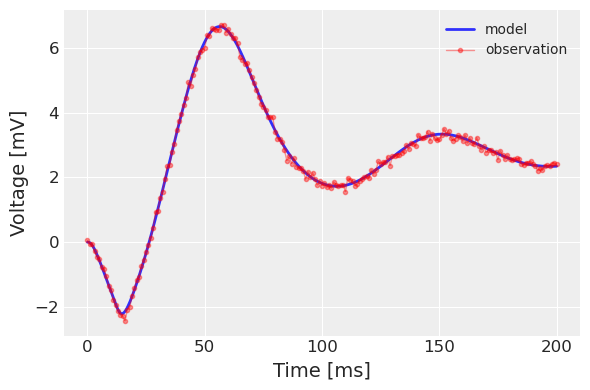

In [32]:
plot_obsrvation(ts, xpy_jax, ts_obs, xpy_obs)

## Prior

Since all the parameters are positive, we place Gamma prior, according to Refs [3,4].

In [33]:
shape=[18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale=[0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)

In [34]:
prior_specs = dict(shape=shape, rate=rate)

In [35]:
def model(data, prior_specs):
    #Data
    dt = data['dt']
    ts = data['ts']
    ds = data['ds']
    nt_obs = data['nt_obs']
    x_init = data['x_init']
    obs_err= data['obs_err']
    xpy_obs = data['xpy_obs']

    # Prior               
    g_1 = npr.sample('g_1', dist.Gamma(prior_specs['shape'][0], prior_specs['rate'][0]))
    g_2 = npr.sample('g_2', dist.Gamma(prior_specs['shape'][1], prior_specs['rate'][1]))
    g_3 = npr.sample('g_3', dist.Gamma(prior_specs['shape'][2], prior_specs['rate'][2]))
    g_4 = npr.sample('g_4', dist.Gamma(prior_specs['shape'][3], prior_specs['rate'][3]))
    delta = npr.sample('delta', dist.Gamma(prior_specs['shape'][4], prior_specs['rate'][4]))
    tau_i = npr.sample('tau_i', dist.Gamma(prior_specs['shape'][5], prior_specs['rate'][5]))
    h_i = npr.sample('h_i', dist.Gamma(prior_specs['shape'][6], prior_specs['rate'][6]))
    tau_e = npr.sample('tau_e', dist.Gamma(prior_specs['shape'][7], prior_specs['rate'][7]))
    h_e = npr.sample('h_e', dist.Gamma(prior_specs['shape'][8], prior_specs['rate'][8]))
    u = npr.sample('u', dist.Gamma(prior_specs['shape'][9], prior_specs['rate'][9]))
     
    #Parameters    
    params_samples=[g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]
    
    #Forward model
    xpy_hat=ERP_JAXOdeintSimuator(x_init, ts, params_samples)[::ds]
    
    # Likelihood
    with plate('data', size=nt_obs):
        xpy_model = npr.deterministic('xpy_model', xpy_hat)
        npr.sample('xpy_obs', dist.Normal(xpy_model, sigma_true), obs=xpy_obs)

In [36]:
with npr.handlers.seed(rng_seed=1):
    trace = npr.handlers.trace(model).get_trace(data, prior_specs)
print(npr.util.format_shapes(trace))

Trace Shapes:      
 Param Sites:      
Sample Sites:      
     g_1 dist     |
        value     |
     g_2 dist     |
        value     |
     g_3 dist     |
        value     |
     g_4 dist     |
        value     |
   delta dist     |
        value     |
   tau_i dist     |
        value     |
     h_i dist     |
        value     |
   tau_e dist     |
        value     |
     h_e dist     |
        value     |
       u dist     |
        value     |
   data plate 201 |
 xpy_obs dist 201 |
        value 201 |


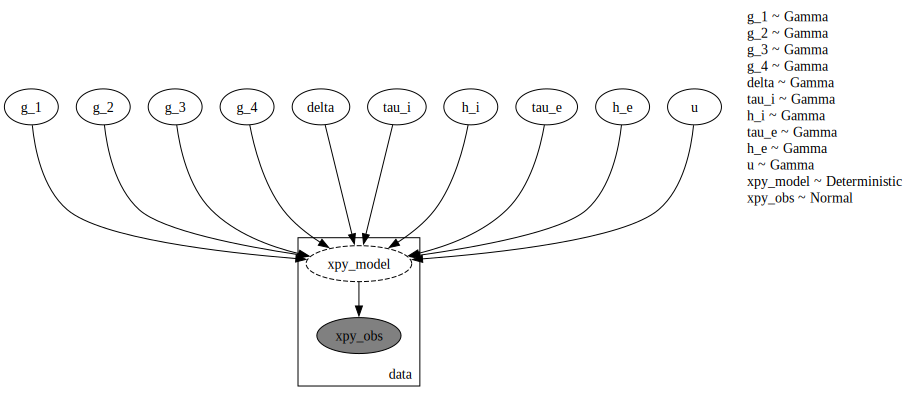

In [37]:
npr.render_model(model, model_args=(data, prior_specs), render_distributions=True, render_params=True)

### Prior predictive check

In [38]:
n_ = 100
prior_predictive = Predictive(model, num_samples=n_)
prior_predictions = prior_predictive(rng_key, data, prior_specs)

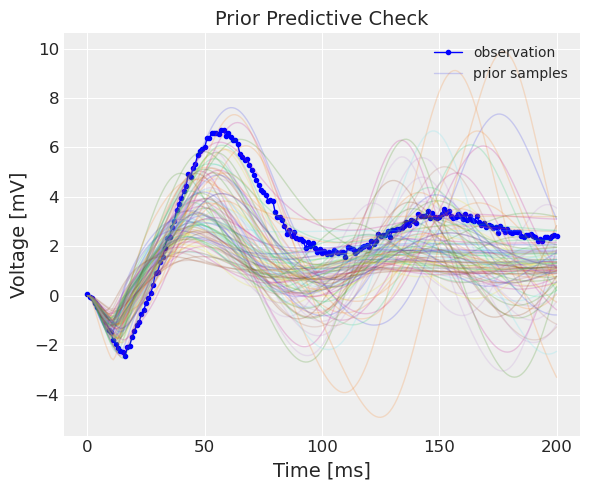

In [39]:
title='Prior Predictive Check'
plot_priorcheck(ts_obs, xpy_obs, prior_predictions, n_, title)

## NUTS sampling 

 Due to large dimentionality of problem and the nonlinear relation between parameeters, the multimodality is omnipresence in this case. In the follwing , we run 4 NUTS chains with default configurations that operates across diverse problems, but not necessarliy leads to convergence. Then we tune the algorithmic parameetrs for better convergence, however, resulting in multimodality. Finnaly, we propose the weighted stacking the chains as a solution to deal with this challnge. 

NOTES: By default set-up, the chains may converge or not. In particular, it may be seen that some samples hits the max tree-depth, which then lead to no convergence. The convergence can be checked by monitoring the \hat R, close to 1 as a rule of thumb, also the Rank Plot, and Effective Sample Size (EES) which we will see in the following.

Now we run the chains at the tail of prior to get convergence for all chains.

In [40]:
n_warmup, n_samples, n_chains= 200, 200, 4

In [41]:
tails_5th_percentile=tails_percentile(my_var_names, prior_predictions, 0.05)    
init_to_low_prob = init_to_value(values=tails_5th_percentile)

In [42]:
# NUTS set up
kernel = NUTS(model, max_tree_depth=12,  dense_mass=False, adapt_step_size=True, init_strategy=init_to_low_prob)
mcmc= MCMC(kernel, num_warmup=n_warmup, num_samples=n_samples, num_chains=n_chains, chain_method='parallel')

In [43]:
#RUN NUTS
start_time = time.time()

mcmc.run(rng_key, data, prior_specs, extra_fields=('potential_energy', 'num_steps', 'diverging'))

print(" All Chains using NUTS' Numpyro took (sec):" , (time.time() - start_time))

sample: 100%|██████████████████████████████| 400/400 [00:40<00:00,  9.91it/s, 255 steps of size 1.35e-02. acc. prob=0.94]


 All Chains using NUTS' Numpyro took (sec): 169.12740778923035


The values of r_hat ~1 show the convergence. This convergence leads to a large effective sample size.

In [44]:
mcmc.print_summary(exclude_deterministic=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta     12.84      0.37     12.84     12.26     13.48    400.31      1.01
       g_1      0.51      0.13      0.50      0.33      0.75    737.58      1.00
       g_2      0.64      0.08      0.63      0.51      0.77    381.16      1.01
       g_3      0.15      0.02      0.15      0.11      0.18    538.86      1.01
       g_4      0.21      0.03      0.20      0.16      0.26    592.11      1.01
       h_e      2.03      0.24      2.03      1.60      2.36    317.24      1.01
       h_i     18.33      3.04     18.20     13.94     23.58    622.41      1.00
     tau_e      7.36      0.19      7.36      7.04      7.67    405.91      1.01
     tau_i      5.83      0.07      5.83      5.72      5.94   1607.74      1.00
         u      3.49      0.57      3.43      2.63      4.40    698.56      1.00

Number of divergences: 0


In [45]:
lp = -mcmc.get_extra_fields()['potential_energy']
print('Expected log joint density: {:.2f}'.format(np.mean(lp)))

Expected log joint density: 185.72


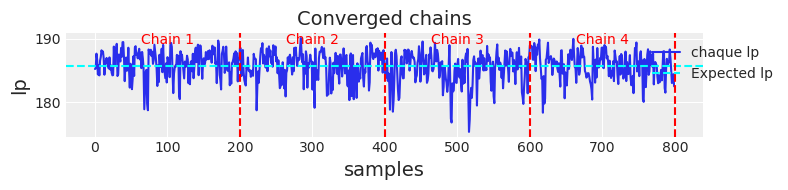

In [46]:
title='Converged chains'
plot_lp_chains(lp, n_chains, title)

### Posterior 

In [47]:
# Get posterior samples
posterior_samples = mcmc.get_samples(group_by_chain=True)
pooled_posterior_samples = mcmc.get_samples()

vizualize with arviz

In [48]:
az_obj = az.from_numpyro(mcmc)

showing the posterior samples of all chains

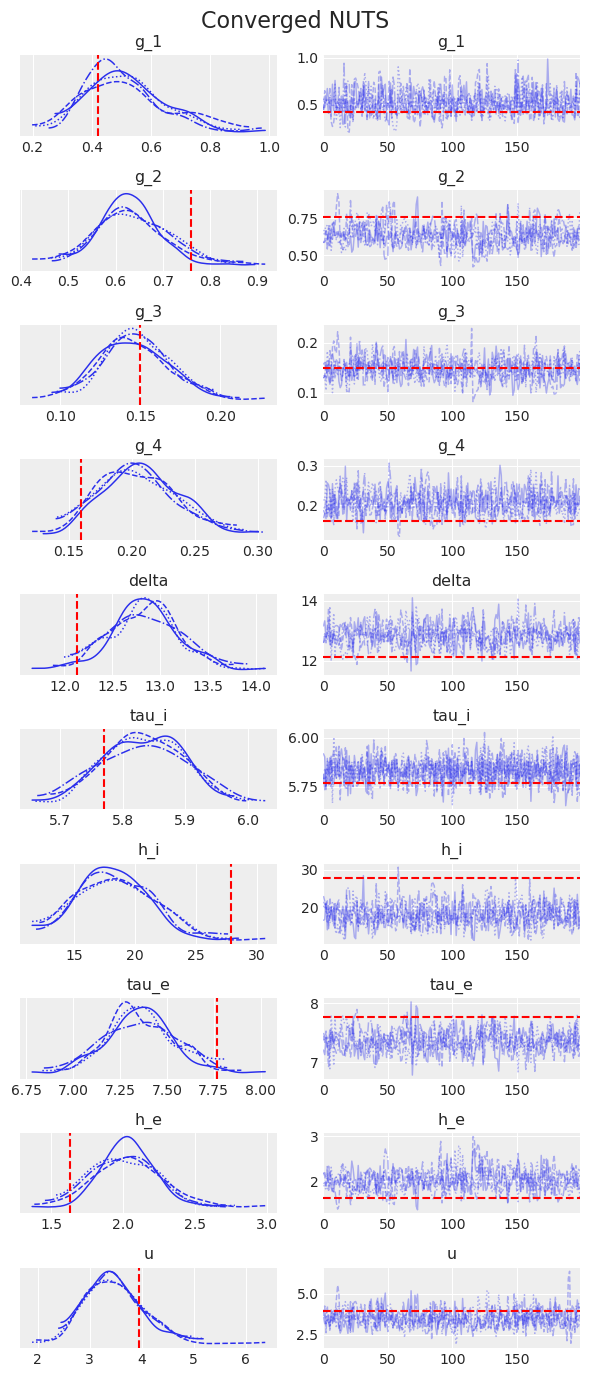

In [49]:
axes = az.plot_trace(
    az_obj,
    var_names=my_var_names,
    compact=True,
    kind="trace",
    backend_kwargs={"figsize": (6, 14), "layout": "constrained"},)

for ax, true_val in zip(axes[:, 0], theta_true):
    ax.axvline(x=true_val, color='red', linestyle='--')  
for ax, true_val in zip(axes[:, 1], theta_true):
    ax.axhline(y=true_val, color='red', linestyle='--')
    
plt.gcf().suptitle("Converged NUTS", fontsize=16)
plt.tight_layout();

In [50]:
chains_pooled = az_obj.posterior[my_var_names].to_array().values.reshape(n_params, -1)
params_map_pooled=calcula_map(chains_pooled)

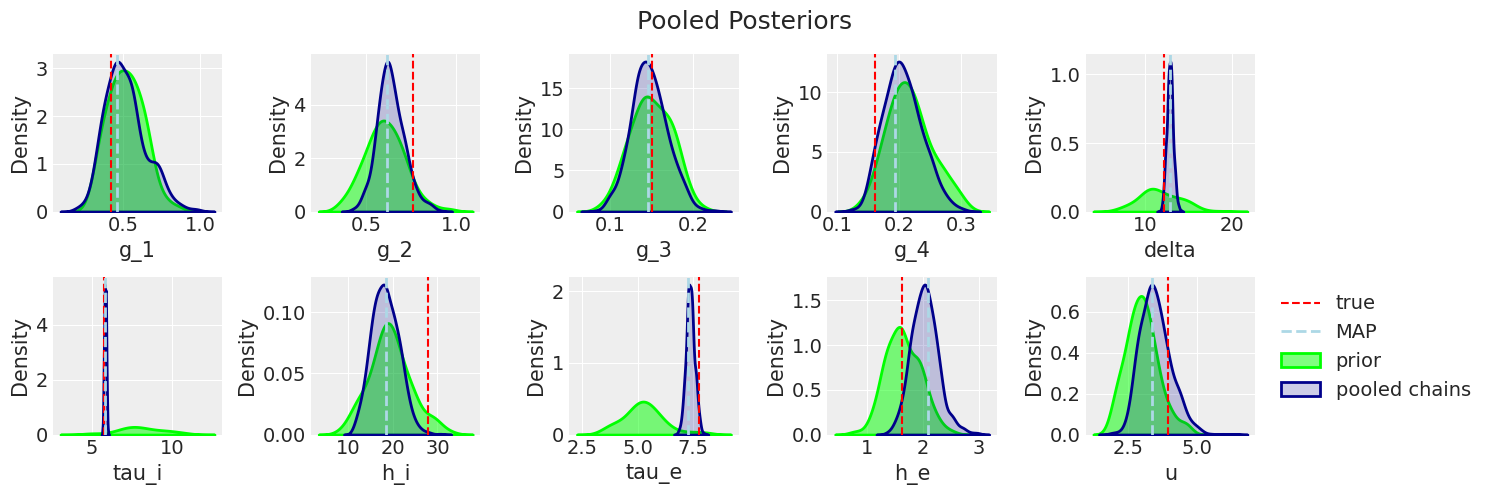

In [51]:
title="Pooled Posteriors"
plot_posterior_pooled(my_var_names, theta_true, prior_predictions, chains_pooled, title)

### Fit and Posterior predictive check 

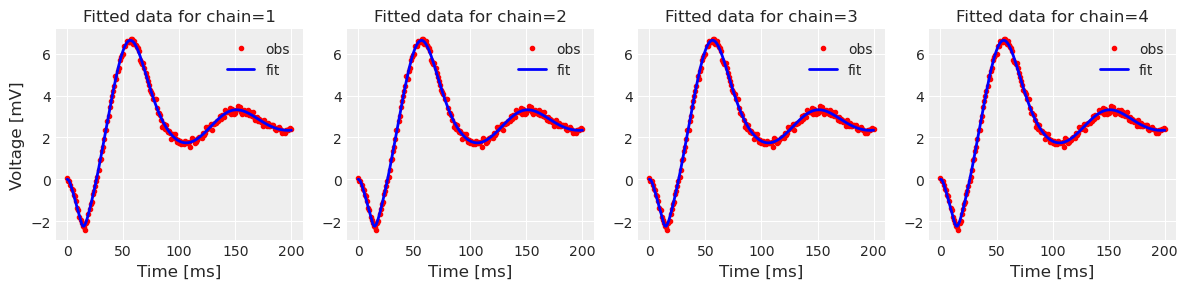

In [52]:
plot_fitted(data, az_obj.posterior)

In [53]:
pooled_posterior_predictive = Predictive(model=model, posterior_samples=pooled_posterior_samples)
rng_key, rng_subkey = random.split(key=rng_key)
pooled_posterior_predictive_samples = pooled_posterior_predictive(rng_subkey, data, prior_specs)

ppc_=pooled_posterior_predictive_samples['xpy_model']
xpy_per05_pooled=np.quantile(ppc_, 0.05, axis=0)
xpy_per95_pooled=np.quantile(ppc_, 0.95, axis=0)

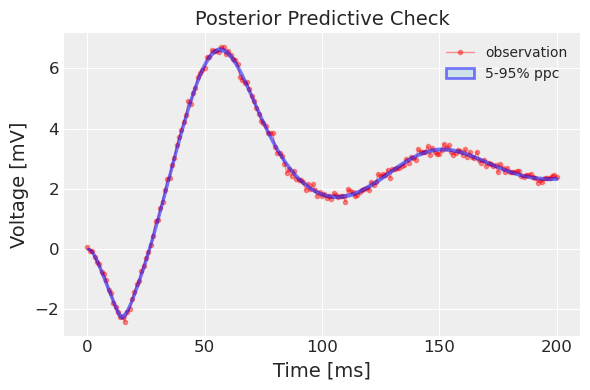

In [54]:
title='Posterior Predictive Check'
plot_posteriorcheck(data, xpy_per05_pooled, xpy_per95_pooled, title)

In [55]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Apr 18 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

numpyro   : 0.14.0
jax       : 0.4.23
seaborn   : 0.12.2
arviz     : 0.17.1
numpy     : 1.24.3
sys       : 3.11.7 (main, Dec 15 2023, 12:09:04) [Clang 14.0.6 ]
pathlib   : 1.0.1
matplotlib: 3.8.0

Watermark: 2.4.3

